In [196]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import folium
import time
from datetime import datetime as dt
from geopy.distance import geodesic
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans, KMeans


from dask.diagnostics import ProgressBar

In [194]:
plt.style.use('ggplot')
tqdm.pandas()
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(10,6)})

In [2]:
pd.options.display.float_format = '{:20,.5f}'.format

In [3]:
data_2015_jan = dd.read_csv('./dataset/2015/yellow_tripdata_2015-01.csv')
print(data_2015_jan.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [4]:
data_2015_jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59000,-73.99390,40.75011,1,N,-73.97478,40.75062,1,12.00000,1.00000,0.50000,3.25000,0.00000,0.30000,17.05000
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30000,-74.00165,40.72424,1,N,-73.99442,40.75911,1,14.50000,0.50000,0.50000,2.00000,0.00000,0.30000,17.80000
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80000,-73.96334,40.80279,1,N,-73.95182,40.82441,2,9.50000,0.50000,0.50000,0.00000,0.00000,0.30000,10.80000
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50000,-74.00909,40.71382,1,N,-74.00433,40.71999,2,3.50000,0.50000,0.50000,0.00000,0.00000,0.30000,4.80000
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00000,-73.97118,40.76243,1,N,-74.00418,40.74265,2,15.00000,0.50000,0.50000,0.00000,0.00000,0.30000,16.30000


In [5]:
# data_2015_jan.visualize()

## Data Cleaning

#### Remove the pickup outliers

We remove all the pickup locations that are not in the vicinity in the NewYork city.

In [6]:
outlier_locations = data_2015_jan[((data_2015_jan.pickup_longitude <= -74.15) | 
                                   (data_2015_jan.pickup_latitude <= 40.5774)| \
                                   (data_2015_jan.pickup_longitude >= -73.7004) | 
                                   (data_2015_jan.pickup_latitude >= 40.9176))]
sl = outlier_locations.loc[0:10000, ['pickup_latitude',
                                    'pickup_longitude']]
sl = sl[sl.pickup_latitude != 0.0]
map_osm = folium.Map(location=[40.734695, -73.990372], 
                     width='70%', height='70%',
                     tiles='Stamen Toner')
for _, loc in sl.iterrows():
    folium.Marker([loc['pickup_latitude'], 
                   loc['pickup_longitude']]).add_to(map_osm)
map_osm

In [7]:
data_2015_jan= data_2015_jan[((data_2015_jan.pickup_longitude >= -74.15) & 
                              (data_2015_jan.pickup_latitude >= 40.5774) &
                              (data_2015_jan.pickup_longitude <= -73.7004) & 
                              (data_2015_jan.pickup_latitude <= 40.9176))]

#### Remove the duration outliers

In [8]:
%%time
## Code Courtesy: AAIC

#The timestamps are converted to unix so as to get duration(trip-time) & 
# speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" 
# we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(dt.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(df):
    duration = df[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup)) / float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = df[['passenger_count','trip_distance','pickup_longitude',
                    'pickup_latitude','dropoff_longitude',
                    'dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60 * (new_frame['trip_distance'] / new_frame['trip_times'])
    
    return new_frame

# print(frame_with_durations.head())
#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378
data_2015_jan_with_durations = return_with_trip_times(data_2015_jan)

CPU times: user 7min 33s, sys: 1min 3s, total: 8min 37s
Wall time: 6min 52s


In [9]:
data_2015_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59000,-73.99390,40.75011,-73.97478,40.75062,17.05000,18.05000,"1,421,348,739.00000",5.28532
1,1,3.30000,-74.00165,40.72424,-73.99442,40.75911,17.80000,19.83333,"1,420,922,018.00000",9.98319
2,1,1.80000,-73.96334,40.80279,-73.95182,40.82441,10.80000,10.05000,"1,420,922,018.00000",10.74627
3,1,0.50000,-74.00909,40.71382,-74.00433,40.71999,4.80000,1.86667,"1,420,922,019.00000",16.07143
4,1,3.00000,-73.97118,40.76243,-74.00418,40.74265,16.30000,19.31667,"1,420,922,019.00000",9.31838


In [10]:
data_2015_jan_with_durations['trip_times'].quantile(np.arange(0, 1.1, 0.1))

0.00000           -1,211.01667
0.10000                3.85000
0.20000                5.40000
0.30000                6.83333
0.40000                8.31667
0.50000                9.96667
0.60000               11.88333
0.70000               14.30000
0.80000               17.65000
0.90000               23.46667
1.00000           79,925.35000
Name: trip_times, dtype: float64

In [11]:
data_2015_jan_with_durations['trip_times'].quantile(np.arange(0.9, 1.01, 0.01))

0.90000               23.46667
0.91000               24.36667
0.92000               25.40000
0.93000               26.56667
0.94000               27.95000
0.95000               29.60000
0.96000               31.71667
0.97000               34.50000
0.98000               38.75000
0.99000               46.80000
1.00000           79,925.35000
Name: trip_times, dtype: float64

In [12]:
data_2015_jan_with_durations.trip_times.describe()

count       12,501,244.00000
mean                13.31070
std                 49.74727
min             -1,211.01667
25%                  6.11667
50%                  9.96667
75%                 15.80000
max             79,925.35000
Name: trip_times, dtype: float64

In [13]:
data_2015_jan_with_durations = data_2015_jan_with_durations[(data_2015_jan_with_durations.trip_times >= 1.0) &
                                                            (data_2015_jan_with_durations.trip_times <= 48.0)]

In [14]:
data_2015_jan_with_durations.shape

(12304498, 10)

#### Remove the Speed outliers

In [15]:
data_2015_jan_with_durations['Speed'].quantile(np.arange(0, 1.1, 0.1))

0.00000                0.00000
0.10000                6.41096
0.20000                7.80347
0.30000                8.91743
0.40000                9.96310
0.50000               11.04294
0.60000               12.25131
0.70000               13.74545
0.80000               15.88235
0.90000               20.08696
1.00000      192,857,142.85714
Name: Speed, dtype: float64

In [16]:
data_2015_jan_with_durations['Speed'].quantile(np.arange(0.9, 1.01, 0.01))

0.90000               20.08696
0.91000               20.82645
0.92000               21.68675
0.93000               22.67717
0.94000               23.82353
0.95000               25.17678
0.96000               26.81319
0.97000               28.85017
0.98000               31.59240
0.99000               35.74468
1.00000      192,857,142.85714
Name: Speed, dtype: float64

In [17]:
data_2015_jan_with_durations['Speed'].quantile(np.arange(0.99, 1.001, 0.001))

0.99000               35.74468
0.99100               36.30252
0.99200               36.90377
0.99300               37.57282
0.99400               38.31016
0.99500               39.15119
0.99600               40.11887
0.99700               41.29228
0.99800               42.81363
0.99900               45.22269
1.00000      192,857,142.85714
Name: Speed, dtype: float64

In [18]:
data_2015_jan_with_durations = data_2015_jan_with_durations[
    (data_2015_jan_with_durations.Speed > 0.0) &
    (data_2015_jan_with_durations.Speed <= 46.0)]

In [19]:
data_2015_jan_with_durations.shape

(12281114, 10)

#### Remove the total fare outliers

In [24]:
data_2015_jan_with_durations['total_amount'].quantile(np.arange(0.99, 1.001, 0.001))

0.99000               63.13000
0.99100               63.80000
0.99200               66.00000
0.99300               68.13000
0.99400               69.60000
0.99500               69.69000
0.99600               69.75000
0.99700               70.95000
0.99800               73.20000
0.99900               86.45000
1.00000        3,950,611.60000
Name: total_amount, dtype: float64

In [25]:
## Taking fare threshold to be 1000. Courtesy to AAIC
data_2015_jan_with_durations = data_2015_jan_with_durations[
    (data_2015_jan_with_durations.total_amount >= 0.0) &
    (data_2015_jan_with_durations.total_amount <= 1000.0)]

In [26]:
data_2015_jan_with_durations.shape

(12278984, 10)

In [28]:
data_2015_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59000,-73.99390,40.75011,-73.97478,40.75062,17.05000,18.05000,"1,421,348,739.00000",5.28532
1,1,3.30000,-74.00165,40.72424,-73.99442,40.75911,17.80000,19.83333,"1,420,922,018.00000",9.98319
2,1,1.80000,-73.96334,40.80279,-73.95182,40.82441,10.80000,10.05000,"1,420,922,018.00000",10.74627
3,1,0.50000,-74.00909,40.71382,-74.00433,40.71999,4.80000,1.86667,"1,420,922,019.00000",16.07143
4,1,3.00000,-73.97118,40.76243,-74.00418,40.74265,16.30000,19.31667,"1,420,922,019.00000",9.31838


## Segment the NYC region into smaller regions

#### Getting the best number of smaller regions

In [134]:
pickup_cords = data_2015_jan_with_durations[['pickup_latitude', 'pickup_longitude']].values

In [130]:
def get_cluster_performance(cluster_centers, threshold):
    """
    It measures and report the cluster performance 
    by calculating the average number of clusters
    more than and less than the `threshold` inter-cluster
    distance and also reprots the minimum and maximum 
    distance betweent the clusters.
    
    :param cluster_centers: <np.ndarray> All the cluster centers
    :param threshold: <float> Distance in miles considered as threshold 
    """
    k = len(cluster_centers)
    nice_points = 0
    wrong_points = 0
    distances = []
    for i in range(0, k):
        for j in range(0, k):
            if i != j:
                distance = geodesic(cluster_centers[i], 
                                    cluster_centers[j]).miles
                if distance < threshold:
                    nice_points += 1
                else:
                    wrong_points += 1
                distances.append(distance)
    print('•' * 20, end='')
    print(' k={} '.format(k), end='')
    print('•' * 20)
    print('• Avg. number of clusters within {} miles: {}'.format(threshold, 
                                                               np.ceil(nice_points / k)))
    print('• Avg. number of clusters not within {} miles: {}'.format(threshold, 
                                                               np.ceil(wrong_points / k)))
    print('• Minimum distance between clusters: ', min(distances))
    print('• Maximum distance between clusters:', max(distances))
    print('•' * 45)

In [143]:
def get_clusters(data: np.ndarray, k: int) -> np.ndarray:
    """
    This fits the data using `k` clusters on the `data` and
    returns the k cluster centers.
    
    :param data: <np.ndarray> Data to cluster
    :param k: <int> Number of cluster centers
    """
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    assert(len(centers) == k)
    return centers

In [144]:
for k in range(10, 100, 10):
    centers = get_clusters(pickup_cords, k)
    get_cluster_performance(centers, 2.0)

•••••••••••••••••••• k=10 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 2.0
• Avg. number of clusters not within 2.0 miles: 8.0
• Minimum distance between clusters:  0.9157176298693095
• Maximum distance between clusters: 14.171969666790561
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=20 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 5.0
• Avg. number of clusters not within 2.0 miles: 15.0
• Minimum distance between clusters:  0.5181349359895029
• Maximum distance between clusters: 14.18705681181196
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=30 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 8.0
• Avg. number of clusters not within 2.0 miles: 22.0
• Minimum distance between clusters:  0.47148554182798474
• Maximum distance between clusters: 15.756136469491306
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=40 ••••••••••••••••••••
• Avg. number of clusters within 

For me k=50 feels a kind of a sweet spot for a large number of points within the 2 miles threshold value and having minimum cluster distance of 0.3 miles. I guess a driver won't feel weird to travel 0.3 miles for more pickups.

In [145]:
kmeans = MiniBatchKMeans(n_clusters=50, batch_size=10000,random_state=42)
kmeans.fit(pickup_cords)
regions = kmeans.predict(pickup_cords)

In [150]:
regions

array([45, 22, 12, ..., 42, 15, 49], dtype=int32)

In [154]:
data_2015_jan_with_durations['region'] = regions

In [155]:
data_2015_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,region
0,1,1.59000,-73.99390,40.75011,-73.97478,40.75062,17.05000,18.05000,"1,421,348,739.00000",5.28532,45
1,1,3.30000,-74.00165,40.72424,-73.99442,40.75911,17.80000,19.83333,"1,420,922,018.00000",9.98319,22
2,1,1.80000,-73.96334,40.80279,-73.95182,40.82441,10.80000,10.05000,"1,420,922,018.00000",10.74627,12
3,1,0.50000,-74.00909,40.71382,-74.00433,40.71999,4.80000,1.86667,"1,420,922,019.00000",16.07143,21
4,1,3.00000,-73.97118,40.76243,-74.00418,40.74265,16.30000,19.31667,"1,420,922,019.00000",9.31838,27


#### Plotting the cluster centers

In [157]:
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), 
                  popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

#### Plotting the clusters

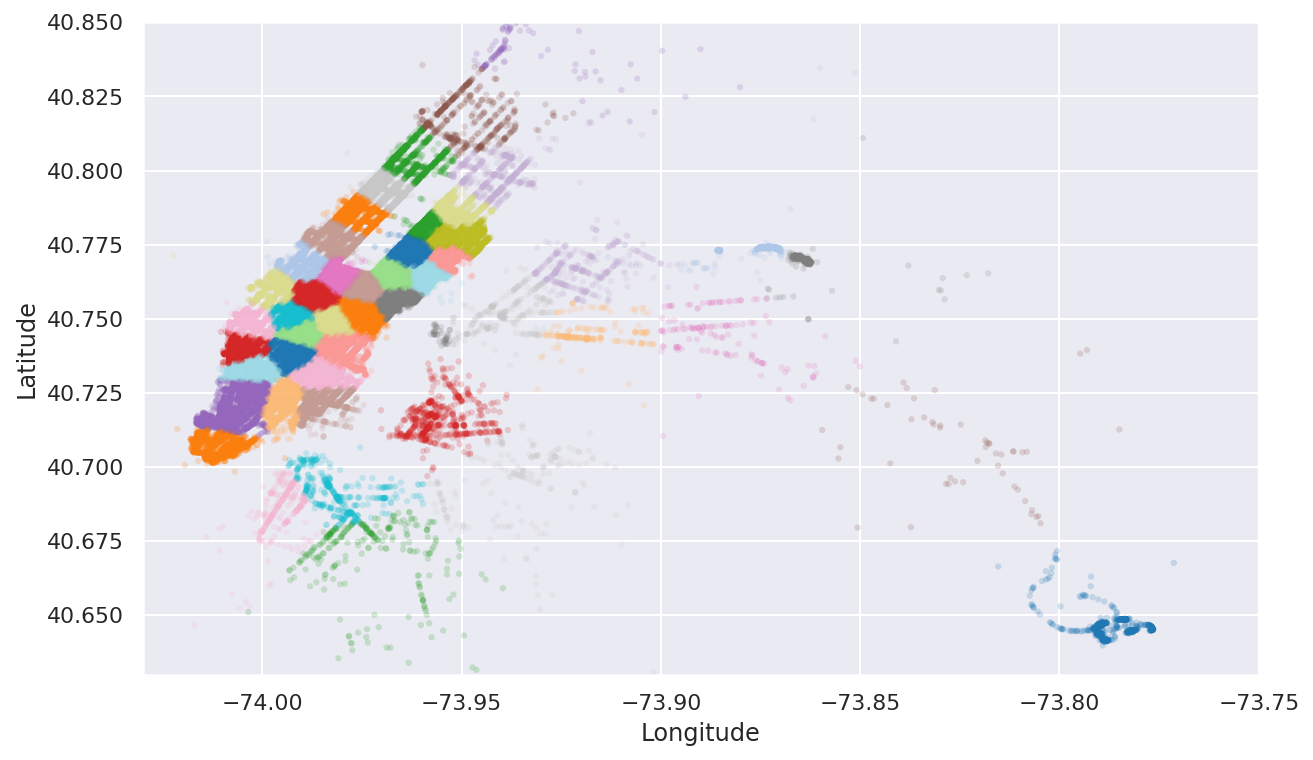

In [162]:
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.region.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(data_2015_jan_with_durations)

## Time binning the compete dataset

In [163]:
data_2015_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,region
0,1,1.59000,-73.99390,40.75011,-73.97478,40.75062,17.05000,18.05000,"1,421,348,739.00000",5.28532,45
1,1,3.30000,-74.00165,40.72424,-73.99442,40.75911,17.80000,19.83333,"1,420,922,018.00000",9.98319,22
2,1,1.80000,-73.96334,40.80279,-73.95182,40.82441,10.80000,10.05000,"1,420,922,018.00000",10.74627,12
3,1,0.50000,-74.00909,40.71382,-74.00433,40.71999,4.80000,1.86667,"1,420,922,019.00000",16.07143,21
4,1,3.00000,-73.97118,40.76243,-74.00418,40.74265,16.30000,19.31667,"1,420,922,019.00000",9.31838,27


In [209]:
def get_time_bin(unixtime, year, timezone='IST', binwidth=10):
    """
    Convert the unix timestamp into the right for the year
    given by `year`. Only 2015, 2016, 2017 is possible. It
    also handles the timezone and it split the data into
    `binwidth` size bins.
    
    :param unixtime: <int> Given unix time
    :param year: <int> Given year
    :param timezone: <str> Timezone
    :param binwidth: <int> Binwidth of time binning
    
    >> get_time_bin(1420133700, 2015, timezone='GMT')
    [out]: 105
    >> get_time_bin(1420133700, 2015, timezone='IST')
    [out]: 138
    """
    initial_time = [1420070400, 1451606400, 1483228800]
    first_jan_time = initial_time[year - 2015]
    factor = 60 * binwidth
    if unixtime < first_jan_time:
        raise ValueError('Unixtime {} is before the year {}'.format(unixtime, year))
    if timezone == 'IST':
        return (unixtime - first_jan_time) // factor + 33
    elif timezone == 'UTC' or timezone == 'GMT':
        return (unixtime - first_jan_time) // factor
    else:
        raise NotImplementedError('Other timezomes are not implemented yet')

In [213]:
data_2015_jan_with_durations['time_bins'] = data_2015_jan_with_durations.pickup_times.apply(
    get_time_bin, args=(2015,))

In [220]:
data_2015_jan_with_durations.time_bins.unique().shape

(4464,)

In [225]:
data_2015_jan_with_durations['time_bins'] = data_2015_jan_with_durations.time_bins.astype(int)

In [226]:
jan_2015_df = data_2015_jan_with_durations[['region', 'time_bins', 'trip_distance']].groupby(
    ['region', 'time_bins']).count()

In [227]:
jan_2015_df.head()

trip_distance
region time_bins               
0      33                    38
       34                   101
       35                   199
       36                   146
       37                   137

In [234]:
jan_2015_df.reset_index(inplace=True)

In [238]:
jan_2015_df.time_bins.unique().shape

(4464,)

## Checkpoint 1

In [242]:
jan_2015_df.to_csv('./dataset/2015/jan_2015_df.csv', index=False)